In [4]:
!wget https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv


--2025-12-07 14:08:40--  https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv
Resolving catalog.ourworldindata.org (catalog.ourworldindata.org)... 104.20.21.76, 172.66.164.52, 2606:4700:10::ac42:a434, ...
Connecting to catalog.ourworldindata.org (catalog.ourworldindata.org)|104.20.21.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162704048 (155M)
Saving to: ‘compact.csv.1’

compact.csv.1       100%[===================>] 155.17M   117MB/s    in 1.3s    

2025-12-07 14:08:41 (117 MB/s) - ‘compact.csv.1’ saved [162704048/162704048]



In [10]:
#ODS

import os
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month, sum, max, avg, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.system("pip install -q pyspark")

try:
    spark
except NameError:
    spark = SparkSession.builder.appName("Proposal_Analysis").master("local[*]").getOrCreate()

sns.set_theme(style="whitegrid")

if os.path.exists("warehouse"):
    shutil.rmtree("warehouse")

input_file = "compact.csv"

if os.path.exists(input_file):
    df_raw = spark.read.csv(input_file, header=True, inferSchema=True)
    print(f"ODS Layer: Loaded {df_raw.count()} rows.")
    df_raw.printSchema()
else:
    print(f"Error: File {input_file} not found.")

ODS Layer: Loaded 547060 rows.
root
 |-- country: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- excess_mortality: double (nullable = true)
 |-- excess_mortality_cumulative: double (nullable = true)
 |-- excess_mortality_cumulative_absolute: double (nullable = true)
 |-- excess_mortality_cumulative_per_million: double (nullable = true)
 |-- hosp_patients: integer

In [27]:
# DWD

dwd_path = "warehouse/dwd/covid_clean"

df_dwd = df_raw.withColumn("date", to_date(col("date"), "yyyy-M-d")) \
               .filter(col("continent").isNotNull()) \
               .fillna(0, subset=["new_cases", "new_deaths", "total_cases", "total_deaths"])

df_dwd.write.mode("overwrite").partitionBy("continent").parquet(dwd_path)

print(f"DWD Layer: Data cleaned and saved to {dwd_path}")

df_clean = spark.read.parquet(dwd_path)
print("DWD Layer Sample:")
df_clean.show(5)

DWD Layer: Data cleaned and saved to warehouse/dwd/covid_clean
DWD Layer Sample:
+-------+----------+-----------+---------+------------------+-----------------------+---------------------+------------------------------+------------+----------+-------------------+------------------------+----------------------+-------------------------------+----------------+---------------------------+------------------------------------+---------------------------------------+-------------+-------------------------+----------------------+----------------------------------+------------+------------------------+---------------------+---------------------------------+----------------+-----------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+--------

In [15]:
#skip null columns

def check_cols(df, required_cols):

    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        print(f"skip bc missing columns: {missing}")
        return False
    return True

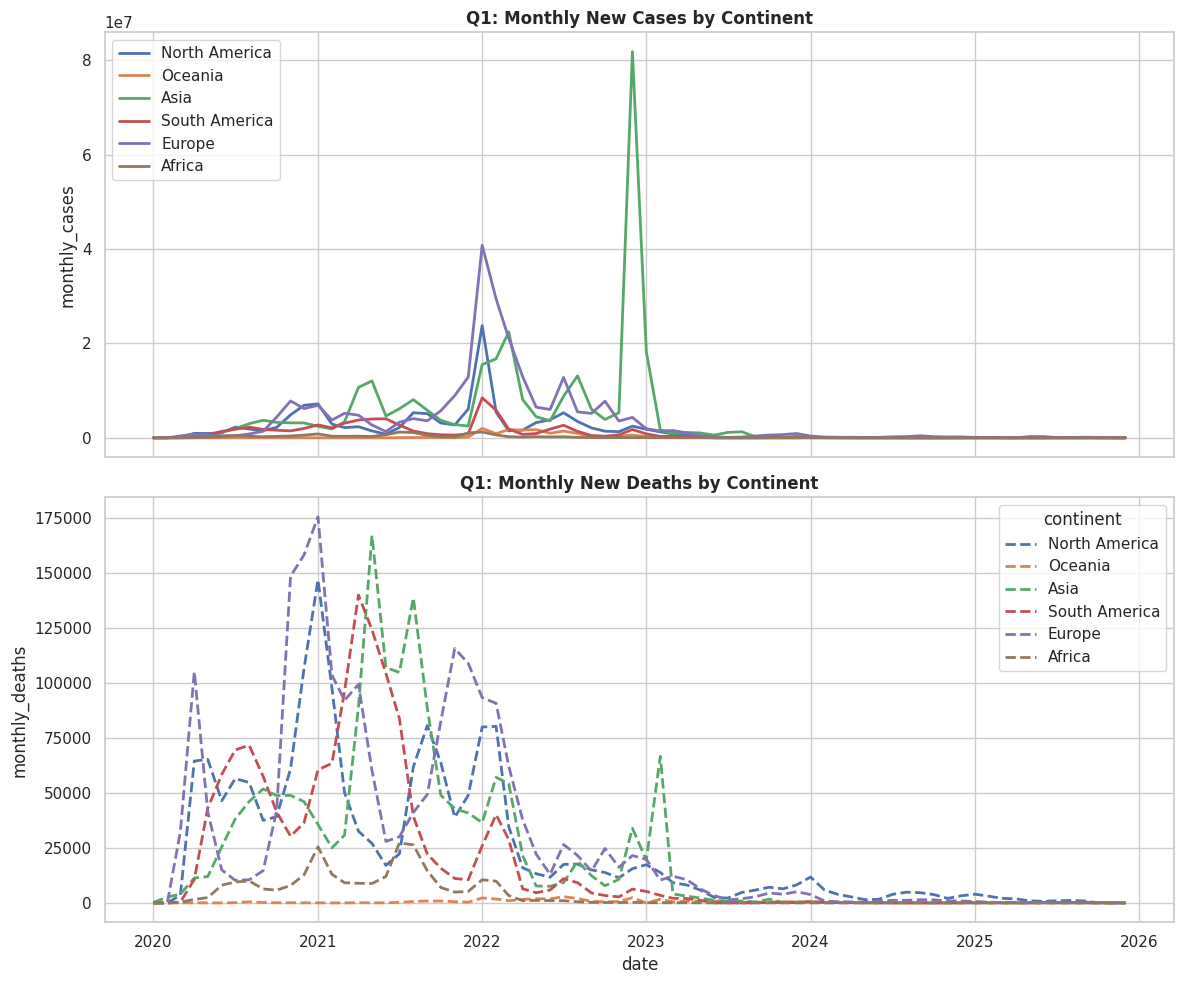

In [28]:
#Q1

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, month, year

try:
    spark
except NameError:
    spark = SparkSession.builder.appName("Q1").master("local[*]").getOrCreate()

dws_path = "warehouse/dws/q1_evolution"
df_clean = spark.read.parquet("warehouse/dwd/covid_clean")

# Fix: Extract 'year' from 'date' column using year(col("date"))
df_q1 = df_clean.groupBy("continent", year(col("date")).alias("year"), month("date").alias("month")) \
    .agg(
        sum("new_cases").alias("monthly_cases"),
        sum("new_deaths").alias("monthly_deaths")
    )

df_q1.write.mode("overwrite").parquet(dws_path)

pdf_q1 = spark.read.parquet(dws_path).toPandas()
pdf_q1['date'] = pd.to_datetime(pdf_q1['year'].astype(str) + '-' + pdf_q1['month'].astype(str) + '-01')
pdf_q1 = pdf_q1.sort_values('date')

sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=pdf_q1, x="date", y="monthly_cases", hue="continent", ax=ax1, linewidth=2)
ax1.set_title("Q1: Monthly New Cases by Continent", fontweight='bold')
ax1.legend(loc='upper left')

sns.lineplot(data=pdf_q1, x="date", y="monthly_deaths", hue="continent", ax=ax2, linestyle='--', linewidth=2)
ax2.set_title("Q1: Monthly New Deaths by Continent", fontweight='bold')

plt.tight_layout()
plt.show()


+
# **这个Q1有一点问题，可以先把图放上去，之后可能需要替换**
+

/tmp/ipython-input-678392009.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_q2, x="infection_rate", y="country", palette="Reds_r")


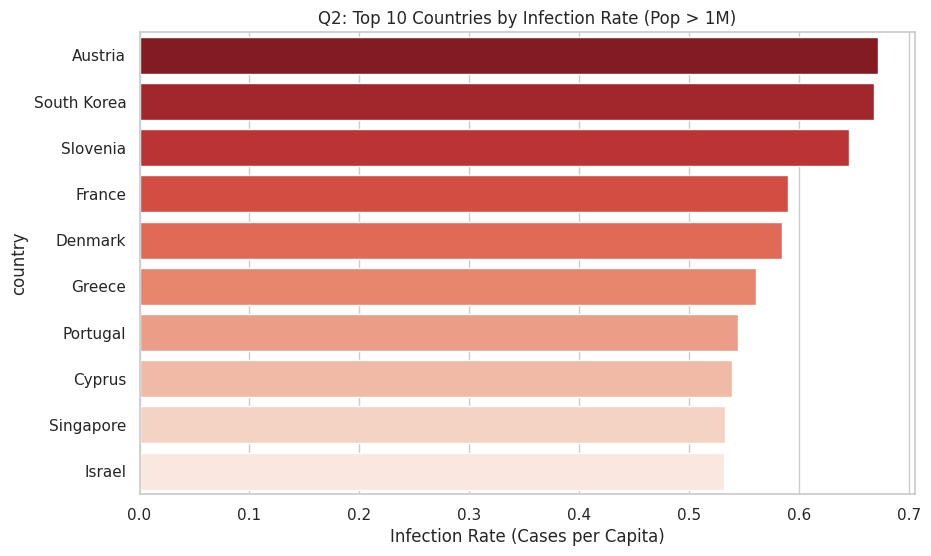

In [30]:
#Q2


dws_q2_path = "warehouse/dws/q2_rates"


if check_cols(df_clean, ["country", "population", "total_cases", "total_deaths"]):
    df_q2_dws = df_clean.filter(col("population") > 1000000) \
        .groupBy("country") \
        .agg(
            max("total_cases").alias("max_cases"),
            max("total_deaths").alias("max_deaths"),
            max("population").alias("pop")
        ) \
        .withColumn("infection_rate", col("max_cases") / col("pop")) \
        .withColumn("mortality_rate", col("max_deaths") / col("pop"))

    df_q2_dws.write.mode("overwrite").parquet(dws_q2_path)

    pdf_q2 = spark.read.parquet(dws_q2_path).orderBy(col("infection_rate").desc()).limit(10).toPandas()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=pdf_q2, x="infection_rate", y="country", palette="Reds_r")
    plt.title("Q2: Top 10 Countries by Infection Rate (Pop > 1M)")
    plt.xlabel("Infection Rate (Cases per Capita)")
    plt.show()
else:
    print("Skipping Q2 due to missing required columns.")

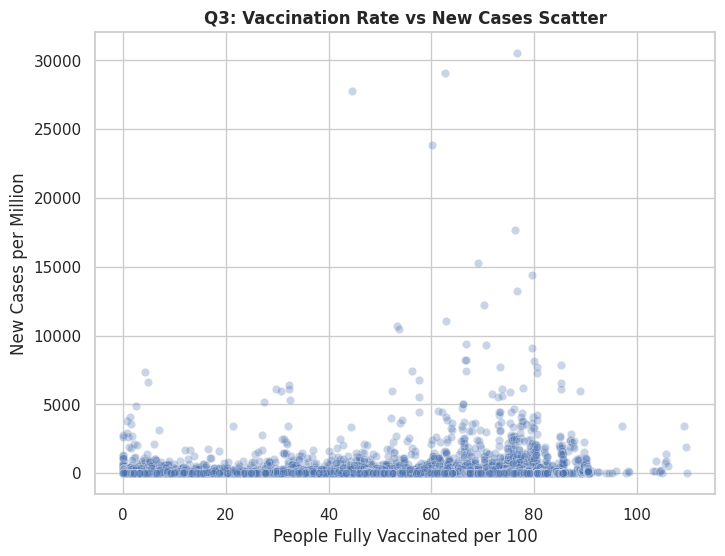

In [34]:
#Q3

dws_path = "warehouse/dws/q3_correlation"
df_clean = spark.read.parquet("warehouse/dwd/covid_clean")

df_q3 = df_clean.select("country", "date", "people_fully_vaccinated_per_hundred", "new_cases_per_million") \
    .filter(col("people_fully_vaccinated_per_hundred").isNotNull()) \
    .filter(col("new_cases_per_million").isNotNull())

df_q3.write.mode("overwrite").parquet(dws_path)

pdf_q3 = spark.read.parquet(dws_path).sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pdf_q3, x="people_fully_vaccinated_per_hundred", y="new_cases_per_million", alpha=0.3)
plt.title("Q3: Vaccination Rate vs New Cases Scatter", fontweight='bold')
plt.xlabel("People Fully Vaccinated per 100")
plt.ylabel("New Cases per Million")
plt.show()

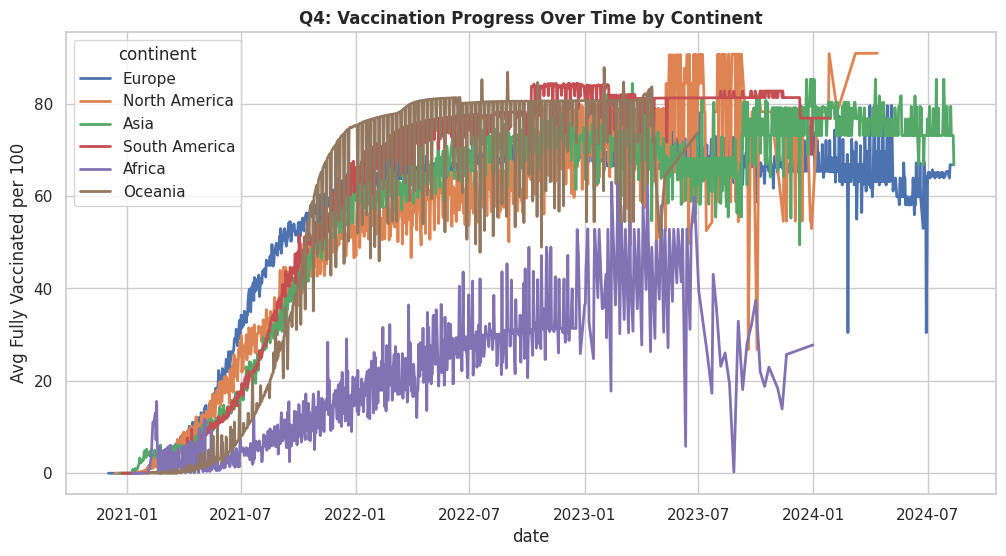

In [32]:
#Q4

from pyspark.sql.functions import avg

dws_path = "warehouse/dws/q4_progress"
df_clean = spark.read.parquet("warehouse/dwd/covid_clean")

df_q4 = df_clean.groupBy("continent", "date") \
    .agg(avg("people_fully_vaccinated_per_hundred").alias("avg_vax_rate")) \
    .filter(col("avg_vax_rate").isNotNull())

df_q4.write.mode("overwrite").parquet(dws_path)

pdf_q4 = spark.read.parquet(dws_path).toPandas().sort_values("date")

plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf_q4, x="date", y="avg_vax_rate", hue="continent", linewidth=2)
plt.title("Q4: Vaccination Progress Over Time by Continent", fontweight='bold')
plt.ylabel("Avg Fully Vaccinated per 100")
plt.show()

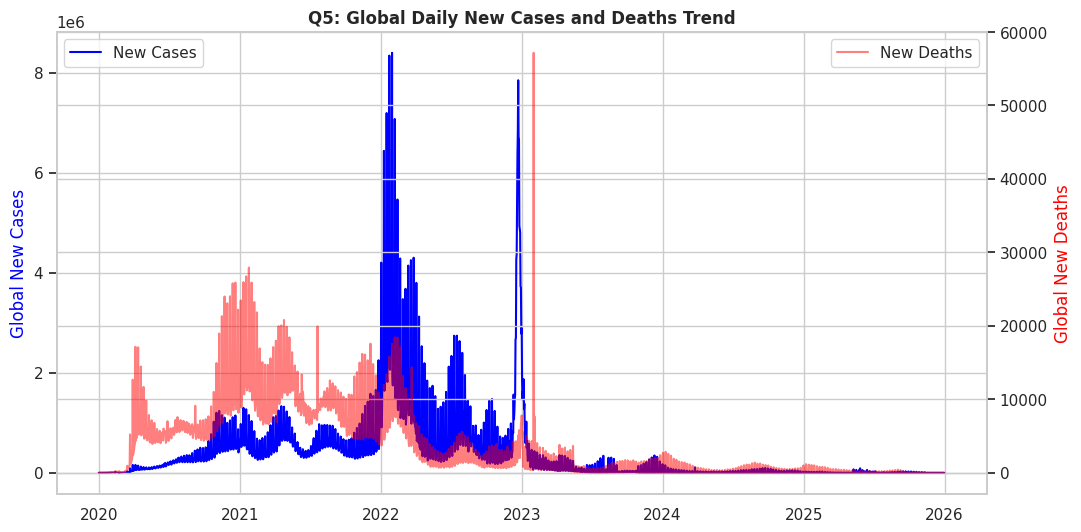

In [33]:
#Q5

dws_path = "warehouse/dws/q5_patterns"
df_clean = spark.read.parquet("warehouse/dwd/covid_clean")

df_q5 = df_clean.groupBy("date") \
    .agg(
        sum("new_cases").alias("global_cases"),
        sum("new_deaths").alias("global_deaths")
    )

df_q5.write.mode("overwrite").parquet(dws_path)

pdf_q5 = spark.read.parquet(dws_path).toPandas().sort_values("date")

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(pdf_q5['date'], pdf_q5['global_cases'], color='blue', label='New Cases')
ax1.set_ylabel('Global New Cases', color='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(pdf_q5['date'], pdf_q5['global_deaths'], color='red', alpha=0.5, label='New Deaths')
ax2.set_ylabel('Global New Deaths', color='red')
ax2.legend(loc='upper right')

plt.title("Q5: Global Daily New Cases and Deaths Trend", fontweight='bold')
plt.show()

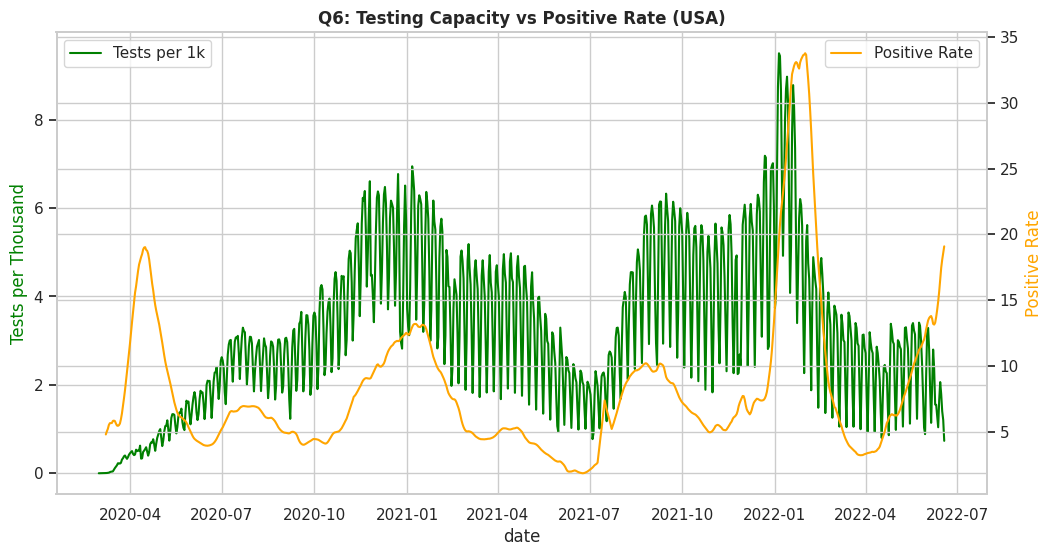

In [37]:
#Q6

dws_path = "warehouse/dws/q6_testing"
df_clean = spark.read.parquet("warehouse/dwd/covid_clean")

df_q6 = df_clean.filter(col("country") == "United States") \
    .select("date", "new_tests_per_thousand", "positive_rate") \
    .filter(col("new_tests_per_thousand").isNotNull())

df_q6.write.mode("overwrite").parquet(dws_path)

pdf_q6 = spark.read.parquet(dws_path).toPandas().sort_values("date")

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(data=pdf_q6, x="date", y="new_tests_per_thousand", ax=ax1, color="green", label="Tests per 1k")
ax1.set_ylabel("Tests per Thousand", color="green")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
sns.lineplot(data=pdf_q6, x="date", y="positive_rate", ax=ax2, color="orange", label="Positive Rate")
ax2.set_ylabel("Positive Rate", color="orange")
ax2.legend(loc='upper right')

plt.title("Q6: Testing Capacity vs Positive Rate (USA)", fontweight='bold')
plt.show()

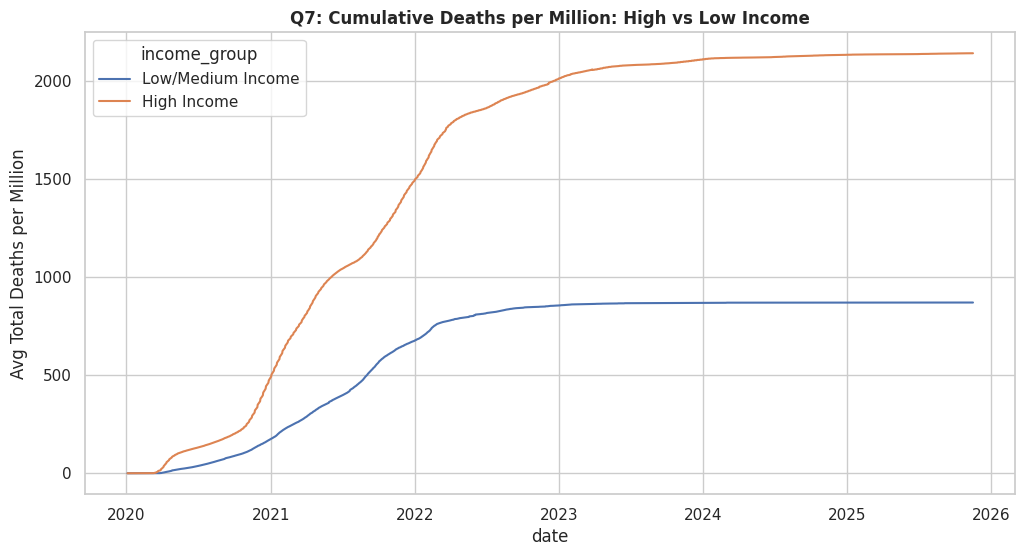

In [40]:
#Q7

from pyspark.sql.functions import when

dws_path = "warehouse/dws/q7_income"
df_clean = spark.read.parquet("warehouse/dwd/covid_clean")

df_q7 = df_clean.withColumn(
        "income_group",
        when(col("gdp_per_capita") > 20000, "High Income").otherwise("Low/Medium Income")
    ) \
    .groupBy("date", "income_group") \
    .agg(avg("total_deaths_per_million").alias("avg_deaths_mil"))

df_q7.write.mode("overwrite").parquet(dws_path)

pdf_q7 = spark.read.parquet(dws_path).toPandas().sort_values("date")

plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf_q7, x="date", y="avg_deaths_mil", hue="income_group")
plt.title("Q7: Cumulative Deaths per Million: High vs Low Income", fontweight='bold')
plt.ylabel("Avg Total Deaths per Million")
plt.show()

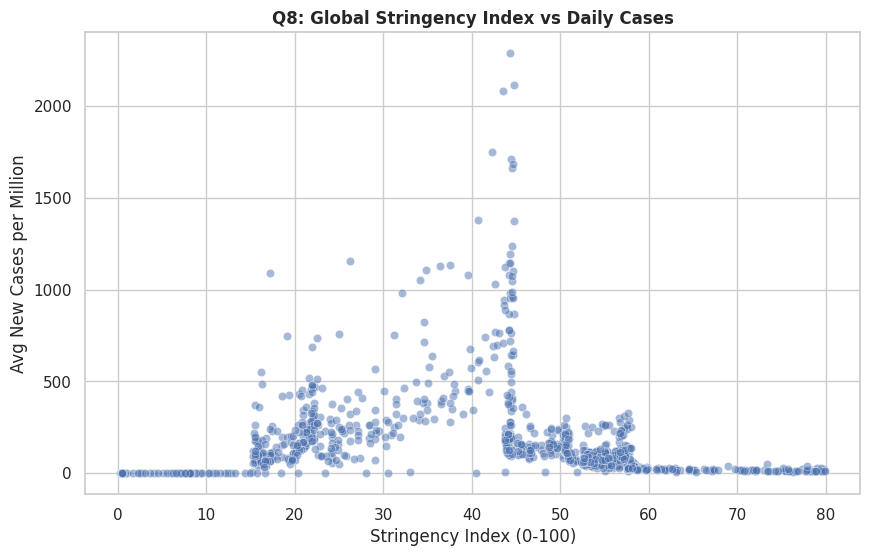

In [38]:
#Q8

dws_path = "warehouse/dws/q8_policy"
df_clean = spark.read.parquet("warehouse/dwd/covid_clean")

df_q8 = df_clean.groupBy("date") \
    .agg(
        avg("stringency_index").alias("avg_stringency"),
        avg("new_cases_per_million").alias("avg_cases")
    ) \
    .filter(col("avg_stringency").isNotNull())

df_q8.write.mode("overwrite").parquet(dws_path)

pdf_q8 = spark.read.parquet(dws_path).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf_q8, x="avg_stringency", y="avg_cases", alpha=0.5)
plt.title("Q8: Global Stringency Index vs Daily Cases", fontweight='bold')
plt.xlabel("Stringency Index (0-100)")
plt.ylabel("Avg New Cases per Million")
plt.show()

**因为数据集改变的问题，有些col的名字本来是country写成了location，有发现哪里有问题或者遗漏请告诉我**